In [1]:
# Project 

# Time Series Analysis and Forecasting

# Revenue Joinville City Hall


In [2]:
# Imports

import requests
import pandas as pd
from datetime import datetime
from dateutil.relativedelta import relativedelta
from time import sleep


In [3]:
# Request revenue data from Joinville's public API.

# Base URL for Joinville City Hall revenue API
BASE_URL = "https://transparencia.joinville.sc.gov.br/epublica-portal/rest/joinville/api/v1/receita"

# Generate periods month-by-month
def generate_monthly_periods(start_date, end_date):
    
    periods = []
    current_date = start_date

    while current_date <= end_date:
        period_str = current_date.strftime("%m/%Y")
        periods.append(period_str)

        # Move to next month
        current_date += relativedelta(months=1)

    return periods
    


In [4]:
# Request Revenue Data from Joinville's public API

def fetch_revenue_data(start_period, end_period, unit_code=0):
    
    params = {
        'periodo_inicial': start_period,
        'periodo_final': end_period,
        'codigo_unidade': unit_code
    }

    print(f"Requesting data for: {params}")

    try:
        response = requests.get(BASE_URL, params=params, timeout=10)

        print(f"Status Code: {response.status_code}")

        if response.status_code in [200, 202]:
            data = response.json()

            total_records = data.get('totalRegistros', 0)
            registros = data.get('registros', [])

            print(f"Data received: {total_records} records.")

            return registros

        else:
            print(f"Error response: {response.text}")
            return None

    except requests.exceptions.Timeout:
        print("Request timed out.")
        return None

    except Exception as e:
        print(f"Unhandled exception: {e}")
        return None


In [5]:
# Collect data for all given periods and return as a list of records

def collect_revenue_data(period_list, unit_code=0):
    all_revenue_records = []

    for period in period_list:
        print(f"\nFetching data for {period}")

        records = fetch_revenue_data(period, period, unit_code=unit_code)

        if records is not None:
            for record in records:
                rev = record['registro']

                unit_name = rev['unidadeGestora']['denominacao']
                economic_category = rev['naturezaReceita']['categoriaEconomica']['denominacao']
                origin = rev['naturezaReceita']['origem']['denominacao']
                revenue_type = rev['receita']['tipoReceita']

                # Loop through each movement (transactions)
                for movement in rev['listMovimentos']:
                    movement_date = movement['dataMovimento']
                    movement_type = movement['tipoMovimento']
                    movement_value = movement['valorMovimento']

                    # Append the structured record to the list
                    all_revenue_records.append({
                        'movement_date': movement_date,
                        'unit': unit_name,
                        'economic_category': economic_category,
                        'origin': origin,
                        'revenue_type': revenue_type,
                        'movement_type': movement_type,
                        'movement_value': movement_value
                    })

        # Pause briefly between requests to avoid overloading the API
        sleep(1)

    return all_revenue_records


In [6]:
# Main function to run the data collection and save to CSV
if __name__ == "__main__":
    # Define your date range (2020 to 2024)
    start_date = datetime(2020, 1, 1)
    end_date = datetime(2024, 12, 1)

    # Generate the list of periods month-by-month
    periods = generate_monthly_periods(start_date, end_date)

    print(f"Generated periods from {periods[0]} to {periods[-1]}")

    # Fetch all revenue records for all periods
    all_records = collect_revenue_data(periods, unit_code=0)

    # Convert the list of records to a DataFrame
    df_revenue = pd.DataFrame(all_records)

    # Convert movement_date to datetime type
    df_revenue['movement_date'] = pd.to_datetime(df_revenue['movement_date'])

    # Preview the data
    print("\nSample of the collected data:")
    print(df_revenue.head())

    # Save the data to a CSV file
    output_filename = 'joinville_revenue_2020_2024.csv'
    df_revenue.to_csv(output_filename, index=False)

    print(f"\nData successfully saved to {output_filename}")

Generated periods from 01/2020 to 12/2024

Fetching data for 01/2020
Requesting data for: {'periodo_inicial': '01/2020', 'periodo_final': '01/2020', 'codigo_unidade': 0}
Status Code: 202
Data received: 356 records.

Fetching data for 02/2020
Requesting data for: {'periodo_inicial': '02/2020', 'periodo_final': '02/2020', 'codigo_unidade': 0}
Status Code: 202
Data received: 156 records.

Fetching data for 03/2020
Requesting data for: {'periodo_inicial': '03/2020', 'periodo_final': '03/2020', 'codigo_unidade': 0}
Status Code: 202
Data received: 154 records.

Fetching data for 04/2020
Requesting data for: {'periodo_inicial': '04/2020', 'periodo_final': '04/2020', 'codigo_unidade': 0}
Status Code: 202
Data received: 146 records.

Fetching data for 05/2020
Requesting data for: {'periodo_inicial': '05/2020', 'periodo_final': '05/2020', 'codigo_unidade': 0}
Status Code: 202
Data received: 149 records.

Fetching data for 06/2020
Requesting data for: {'periodo_inicial': '06/2020', 'periodo_final

In [7]:
# Load Dataset
# This dataset includes monthly revenue records from 2020 to 2024, fetched via the Joinville City Hall public API.
df = pd.read_csv('joinville_revenue_2020_2024.csv')

print("Dataset Shape: ", df.shape)

print(df.head())

Dataset Shape:  (79694, 7)
  movement_date                                     unit   economic_category  \
0    2020-01-01  Prefeitura Municipal de Joinville - PMJ  Receitas Correntes   
1    2020-01-07  Prefeitura Municipal de Joinville - PMJ  Receitas Correntes   
2    2020-01-22  Prefeitura Municipal de Joinville - PMJ  Receitas Correntes   
3    2020-01-23  Prefeitura Municipal de Joinville - PMJ  Receitas Correntes   
4    2020-01-30  Prefeitura Municipal de Joinville - PMJ  Receitas Correntes   

                      origin revenue_type           movement_type  \
0  Outras Receitas Correntes        Bruta     Previsão de Receita   
1  Outras Receitas Correntes        Bruta  Arrecadação de receita   
2  Outras Receitas Correntes        Bruta  Arrecadação de receita   
3  Outras Receitas Correntes        Bruta  Arrecadação de receita   
4  Outras Receitas Correntes        Bruta  Arrecadação de receita   

   movement_value  
0         8000.00  
1          101.99  
2          144.95

In [8]:
# Convert to datetime
# This is essential for time series analysis, as it allows us to group data by month/year
df['movement_date'] = pd.to_datetime(df['movement_date'])

# Check data types
print(df.dtypes)

movement_date        datetime64[ns]
unit                         object
economic_category            object
origin                       object
revenue_type                 object
movement_type                object
movement_value              float64
dtype: object


In [9]:
# Basic Summary of Data
# This helps us understand the distribution, average revenue, min/max values, and identify potential outliers
df.describe()


,movement_date,movement_value
count,79694,7.969400e+04
mean,2022-08-16 11:01:43.626371072,4.178695e+05
min,2020-01-01 00:00:00,-1.020425e+08
25%,2021-06-01 00:00:00,1.627375e+02
50%,2022-09-09 00:00:00,1.710305e+03
75%,2023-11-20 00:00:00,1.768222e+04
max,2024-12-31 00:00:00,5.206611e+08
std,NaN,6.556331e+06


In [10]:
# Negative values
negative_count = df[df['movement_value'] < 0].shape[0]

print(f"Negative revenue records: {negative_count}")


Negative revenue records: 3819


In [11]:
df[df['movement_value'] < 0].head(10)  # show the first 10 negative values

# These records are often related to 'Redutora' revenue types such as FUNDEB deductions

,movement_date,unit,economic_category,origin,revenue_type,movement_type,movement_value
141,2020-01-10,Prefeitura Municipal de Joinville - PMJ,Receitas Correntes,Transferências Correntes,Redutora - FUNDEB,Arrecadação de receita,-442683.29
142,2020-01-20,Prefeitura Municipal de Joinville - PMJ,Receitas Correntes,Transferências Correntes,Redutora - FUNDEB,Arrecadação de receita,-192351.70
169,2020-01-01,Prefeitura Municipal de Joinville - PMJ,Receitas Correntes,Transferências Correntes,Redutora - FUNDEB,Previsão de Receita,-9073600.00
171,2020-01-01,Prefeitura Municipal de Joinville - PMJ,Receitas Correntes,Transferências Correntes,Redutora - FUNDEB,Previsão de Receita,-169600.00
172,2020-01-10,Prefeitura Municipal de Joinville - PMJ,Receitas Correntes,Transferências Correntes,Redutora - FUNDEB,Arrecadação de receita,-770.20
173,2020-01-30,Prefeitura Municipal de Joinville - PMJ,Receitas Correntes,Transferências Correntes,Redutora - FUNDEB,Arrecadação de receita,-428.07
175,2020-01-01,Prefeitura Municipal de Joinville - PMJ,Receitas Correntes,Transferências Correntes,Redutora - FUNDEB,Previsão de Receita,-848000.00
197,2020-01-01,Prefeitura Municipal de Joinville - PMJ,Receitas Correntes,Transferências Correntes,Redutora - FUNDEB,Previsão de Receita,-28927400.00
199,2020-01-01,Prefeitura Municipal de Joinville - PMJ,Receitas Correntes,Transferências Correntes,Redutora - FUNDEB,Previsão de Receita,-19758400.00
201,2020-01-01,Prefeitura Municipal de Joinville - PMJ,Receitas Correntes,Transferências Correntes,Redutora - FUNDEB,Previsão de Receita,-2565200.00


In [12]:
# That's normal in Brazilian public finance—they're reductions that account for transfers and deductions in education funding.

In [13]:
# Missing Values

df.isnull().sum()

movement_date        0
unit                 0
economic_category    0
origin               0
revenue_type         0
movement_type        0
movement_value       0
dtype: int64

In [14]:
print(df.columns.tolist())


['movement_date', 'unit', 'economic_category', 'origin', 'revenue_type', 'movement_type', 'movement_value']


In [15]:
# Unique values for each categorical column
print("Units:\n", df['unit'].unique())

print("\nEconomic Categories:\n", df['economic_category'].unique())

print("\nOrigins:\n", df['origin'].unique())

print("\nRevenue Types:\n", df['revenue_type'].unique())

print("\nMovement Types:\n", df['movement_type'].unique())


Units:
 ['Prefeitura Municipal de Joinville - PMJ']

Economic Categories:
 ['Receitas Correntes' 'Receitas de Capital'
 'Receitas Correntes Intraorçamentárias']

Origins:
 ['Outras Receitas Correntes' 'Receita Patrimonial'
 'Transferências de Capital'
 'Impostos, Taxas e Contribuições de Melhoria - Intraorçamentária'
 'Alienação de Bens' 'Impostos, Taxas e Contribuições de Melhoria'
 'Transferências Correntes' 'Operações de Crédito'
 'Outras Receitas de Capital' 'Receita de Serviços' 'Contribuições'
 'Receita Agropecuária' 'Receita Industrial'
 'Outras Receitas Correntes - Intraorçamentária']

Revenue Types:
 ['Bruta' 'Redutora - FUNDEB' 'Redutora - Restituições'
 'Redutora - Retificações' 'Redutora - Outras Deduções'
 'Redutora - Compensações']

Movement Types:
 ['Previsão de Receita' 'Arrecadação de receita' 'Dedução de receita'
 'Reconhecimento de receita' 'Estorno de arrecadação de receita'
 'Estorno de dedução de receita' 'Estorno de reconhecimento de receita']


In [16]:
# Filtering Data
# We exclude 'Previsão de Receita' (forecast) and 'Dedução' (deductions) movements because they don't represent real cash inflows

df_collected = df[df['movement_type'] == 'Arrecadação de receita']

print("Filtered dataset shape(collected revenues):", df_collected.shape)

print(df_collected.head())

Filtered dataset shape(collected revenues): (76635, 7)
  movement_date                                     unit   economic_category  \
1    2020-01-07  Prefeitura Municipal de Joinville - PMJ  Receitas Correntes   
2    2020-01-22  Prefeitura Municipal de Joinville - PMJ  Receitas Correntes   
3    2020-01-23  Prefeitura Municipal de Joinville - PMJ  Receitas Correntes   
4    2020-01-30  Prefeitura Municipal de Joinville - PMJ  Receitas Correntes   
5    2020-01-08  Prefeitura Municipal de Joinville - PMJ  Receitas Correntes   

                      origin revenue_type           movement_type  \
1  Outras Receitas Correntes        Bruta  Arrecadação de receita   
2  Outras Receitas Correntes        Bruta  Arrecadação de receita   
3  Outras Receitas Correntes        Bruta  Arrecadação de receita   
4  Outras Receitas Correntes        Bruta  Arrecadação de receita   
5        Receita Patrimonial        Bruta  Arrecadação de receita   

   movement_value  
1          101.99  
2        

In [17]:
# Grouping revenue by month and origin

monthly_origin_revenue = df_collected.groupby([
    pd.Grouper(key='movement_date', freq='ME'),
    'origin'
])['movement_value'].sum().reset_index()

# Preview the first few records
print(monthly_origin_revenue.head())

  movement_date                                       origin  movement_value
0    2020-01-31                                Contribuições    7.299039e+06
1    2020-01-31  Impostos, Taxas e Contribuições de Melhoria    1.409197e+08
2    2020-01-31                    Outras Receitas Correntes    1.091102e+06
3    2020-01-31                         Receita Agropecuária    2.283000e+01
4    2020-01-31                          Receita Patrimonial    2.525599e+06


In [18]:
# Display numbers in plain (non-scientific) notation
pd.set_option('display.float_format', '{:,.2f}'.format)

print(monthly_origin_revenue.head())


  movement_date                                       origin  movement_value
0    2020-01-31                                Contribuições    7,299,039.25
1    2020-01-31  Impostos, Taxas e Contribuições de Melhoria  140,919,745.36
2    2020-01-31                    Outras Receitas Correntes    1,091,101.96
3    2020-01-31                         Receita Agropecuária           22.83
4    2020-01-31                          Receita Patrimonial    2,525,598.72


In [19]:
# Create a pivot table where rows = month, columns = origin, values = revenue
pivot_origin = monthly_origin_revenue.pivot(
    index='movement_date',
    columns='origin',
    values='movement_value'
)

# Preview the pivot table (first 5 rows)
print(pivot_origin.head())


origin         Alienação de Bens  Contribuições  \
movement_date                                     
2020-01-31                   NaN   7,299,039.25   
2020-02-29                   NaN   5,278,196.38   
2020-03-31                   NaN   5,342,305.76   
2020-04-30                   NaN   5,149,274.93   
2020-05-31                   NaN   3,801,256.69   

origin         Impostos, Taxas e Contribuições de Melhoria  \
movement_date                                                
2020-01-31                                  140,919,745.36   
2020-02-29                                   59,779,412.54   
2020-03-31                                   43,965,408.01   
2020-04-30                                   36,597,730.68   
2020-05-31                                   36,645,004.01   

origin         Operações de Crédito  Outras Receitas Correntes  \
movement_date                                                    
2020-01-31                      NaN               1,091,101.96   
2020-02-2

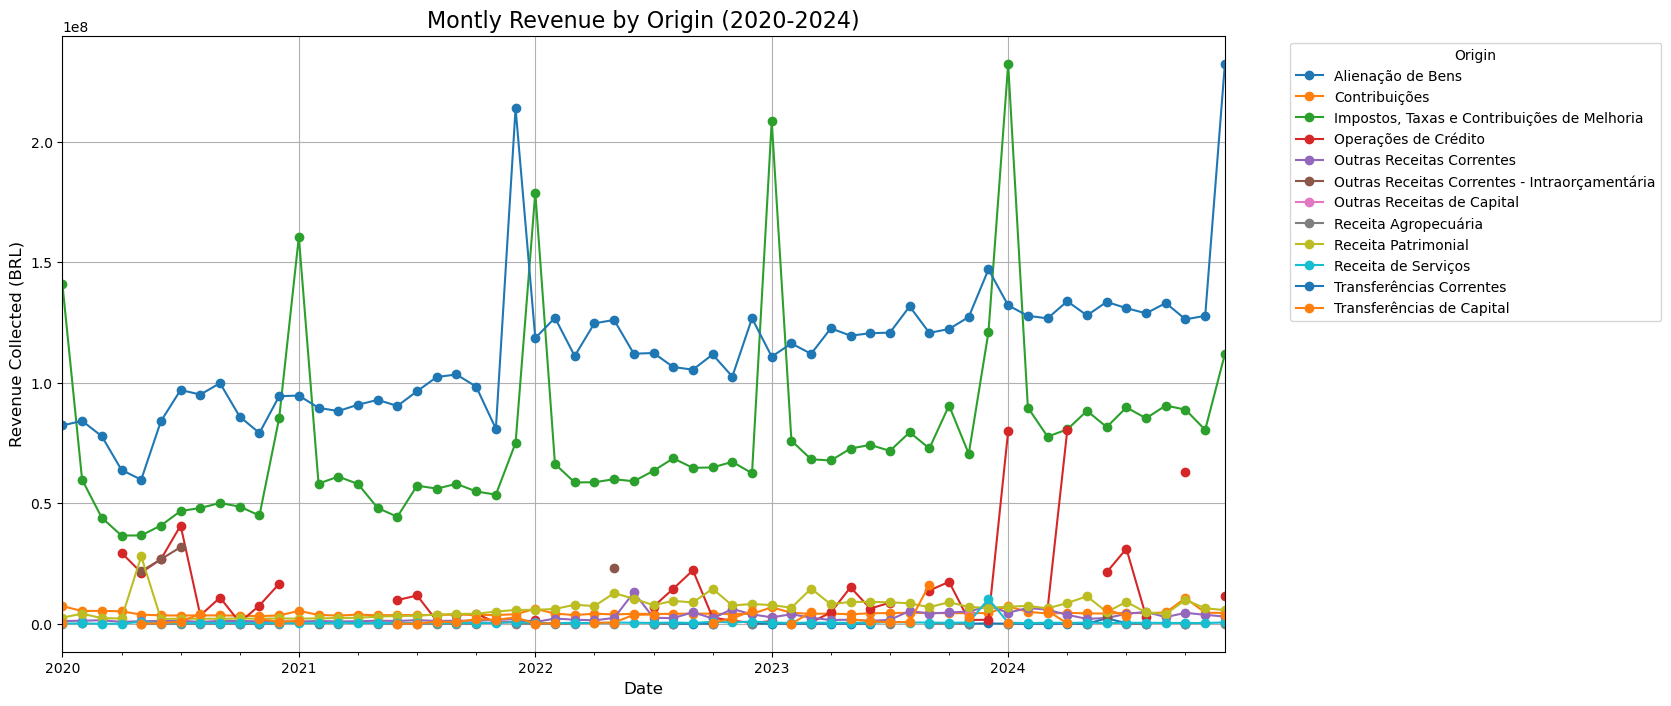

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,8))

pivot_origin.plot(ax=plt.gca(), marker='o')

plt.title('Montly Revenue by Origin (2020-2024)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Revenue Collected (BRL)', fontsize=12)
plt.legend(title='Origin', bbox_to_anchor=(1.05,1), loc='upper left')

plt.grid(True)

plt.show()


In [24]:
# Train Test Split

# Cutoff date for train/test split
train_end_date = '2023-12-31'

# Train dataset: All data before 2024
df_train = df_collected[df_collected['movement_date'] <= train_end_date]

# Test dataset: All data from 2024 onwards
df_test = df_collected[df_collected['movement_date'] > train_end_date]

# Confirm shapes of datasets
print("Train dataset shape:", df_train.shape)
print("Test dataset shape:", df_test.shape)

# Confirm date ranges in each set
print("Train date range:", df_train['movement_date'].min(), "to", df_train['movement_date'].max())
print("Test date range:", df_test['movement_date'].min(), "to", df_test['movement_date'].max())







Train dataset shape: (59502, 7)
Test dataset shape: (17133, 7)
Train date range: 2020-01-02 00:00:00 to 2023-12-31 00:00:00
Test date range: 2024-01-01 00:00:00 to 2024-12-31 00:00:00


In [26]:
# Save train and test datasets to CSV
df_train.to_csv('joinville_revenue_train_2020_2023.csv', index=False)
df_test.to_csv('joinville_revenue_test_2024.csv', index=False)



In [29]:
#!pip install prophet

In [32]:
from prophet import Prophet

# Group by month only

monthly_train = df_train.groupby(
    pd.Grouper(key='movement_date', freq='ME')  # Group by calendar month
)['movement_value'].sum().reset_index()

# Preview
print(monthly_train.head())

#Renaming columns (date and target)

df_prophet_train = monthly_train.rename(columns={
    'movement_date': 'ds',
    'movement_value': 'y'
})

# Preview the data
df_prophet_train.head()


  movement_date  movement_value
0    2020-01-31  234,441,350.94
1    2020-02-29  155,053,344.29
2    2020-03-31  130,881,797.61
3    2020-04-30  137,945,594.59
4    2020-05-31  173,109,881.48


,ds,y
0,2020-01-31,"234,441,350.94"
1,2020-02-29,"155,053,344.29"
2,2020-03-31,"130,881,797.61"
3,2020-04-30,"137,945,594.59"
4,2020-05-31,"173,109,881.48"


In [33]:
# Create the Prophet model
model = Prophet()

# Fit the model on your training data
model.fit(df_prophet_train)

14:15:09 - cmdstanpy - INFO - Chain [1] start processing
14:15:10 - cmdstanpy - INFO - Chain [1] done processing


In [35]:
# Create a dataframe for future dates (12 months into the future)
future = model.make_future_dataframe(periods=12, freq='ME')

# Preview
print(future.tail())


           ds
55 2024-08-31
56 2024-09-30
57 2024-10-31
58 2024-11-30
59 2024-12-31


In [36]:
# Generate predictions
forecast = model.predict(future)

# Preview forecast (showing date, prediction, and confidence intervals)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(12)


,ds,yhat,yhat_lower,yhat_upper
48,2024-01-31,"337,274,041.17","317,438,575.56","358,808,086.40"
49,2024-02-29,"242,505,957.76","220,178,467.81","263,224,140.63"
50,2024-03-31,"219,728,513.27","197,808,916.14","243,436,840.53"
51,2024-04-30,"222,572,726.68","200,372,046.12","244,784,358.18"
52,2024-05-31,"242,546,161.84","220,266,205.74","264,823,255.63"
53,2024-06-30,"251,615,034.43","230,009,955.84","273,058,672.83"
54,2024-07-31,"289,165,862.47","267,612,282.88","312,137,367.16"
55,2024-08-31,"241,078,582.14","218,404,932.06","264,799,067.65"
56,2024-09-30,"252,972,581.10","230,750,120.99","275,129,527.20"
57,2024-10-31,"232,660,151.68","209,811,048.62","254,967,520.28"


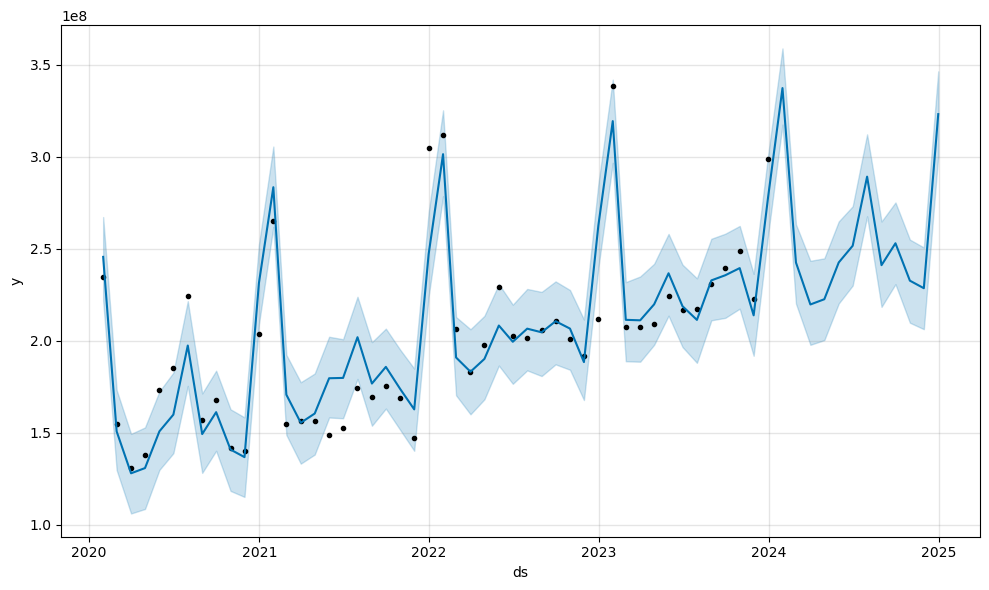

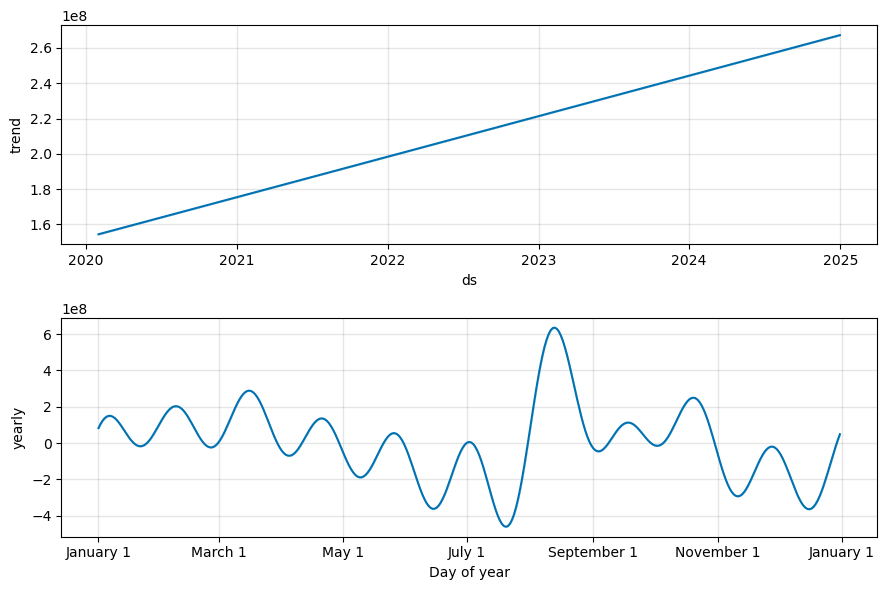

In [37]:
# Plot the forecast
fig1 = model.plot(forecast)

# Plot trend and seasonality components
fig2 = model.plot_components(forecast)


In [40]:
# Extract Prophet forecast for 2024 only
forecast_2024 = forecast[(forecast['ds'] >= '2024-01-01') & (forecast['ds'] <= '2024-12-31')]

# Preview the predictions
forecast_2024[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]


,ds,yhat,yhat_lower,yhat_upper
48,2024-01-31,"337,274,041.17","317,438,575.56","358,808,086.40"
49,2024-02-29,"242,505,957.76","220,178,467.81","263,224,140.63"
50,2024-03-31,"219,728,513.27","197,808,916.14","243,436,840.53"
51,2024-04-30,"222,572,726.68","200,372,046.12","244,784,358.18"
52,2024-05-31,"242,546,161.84","220,266,205.74","264,823,255.63"
53,2024-06-30,"251,615,034.43","230,009,955.84","273,058,672.83"
54,2024-07-31,"289,165,862.47","267,612,282.88","312,137,367.16"
55,2024-08-31,"241,078,582.14","218,404,932.06","264,799,067.65"
56,2024-09-30,"252,972,581.10","230,750,120.99","275,129,527.20"
57,2024-10-31,"232,660,151.68","209,811,048.62","254,967,520.28"


In [43]:
# Group the test data by month to get actual revenue
monthly_test = df_test.groupby(
    pd.Grouper(key='movement_date', freq='ME')
)['movement_value'].sum().reset_index()

# Rename for easier merging
monthly_test.rename(columns={
    'movement_date': 'ds',
    'movement_value': 'actual'
}, inplace=True)

# Preview actuals
print(monthly_test)


           ds         actual
0  2024-01-31 463,856,331.14
1  2024-02-29 236,587,335.94
2  2024-03-31 232,819,295.52
3  2024-04-30 312,076,182.43
4  2024-05-31 234,478,107.09
5  2024-06-30 259,548,417.09
6  2024-07-31 273,216,381.27
7  2024-08-31 231,482,121.12
8  2024-09-30 235,481,167.45
9  2024-10-31 303,627,989.52
10 2024-11-30 223,228,188.71
11 2024-12-31 373,591,522.64


In [44]:
# Merge Prophet predictions with actual data
compare_df = pd.merge(
    forecast_2024[['ds', 'yhat']],
    monthly_test,
    on='ds'
)

# Preview the comparison
print(compare_df)


           ds           yhat         actual
0  2024-01-31 337,274,041.17 463,856,331.14
1  2024-02-29 242,505,957.76 236,587,335.94
2  2024-03-31 219,728,513.27 232,819,295.52
3  2024-04-30 222,572,726.68 312,076,182.43
4  2024-05-31 242,546,161.84 234,478,107.09
5  2024-06-30 251,615,034.43 259,548,417.09
6  2024-07-31 289,165,862.47 273,216,381.27
7  2024-08-31 241,078,582.14 231,482,121.12
8  2024-09-30 252,972,581.10 235,481,167.45
9  2024-10-31 232,660,151.68 303,627,989.52
10 2024-11-30 228,562,711.10 223,228,188.71
11 2024-12-31 323,114,882.44 373,591,522.64


In [45]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(compare_df['actual'], compare_df['yhat'])
print(f'Mean Absolute Error (MAE): {mae:,.2f}')


Mean Absolute Error (MAE): 35,076,078.63


In [46]:
# Custom MAPE function to handle division by zero safely
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = pd.Series(y_true), pd.Series(y_pred)
    return (abs((y_true - y_pred) / y_true).replace([float('inf'), -float('inf')], float('nan')).dropna()).mean() * 100

mape = mean_absolute_percentage_error(compare_df['actual'], compare_df['yhat'])
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')


Mean Absolute Percentage Error (MAPE): 10.61%


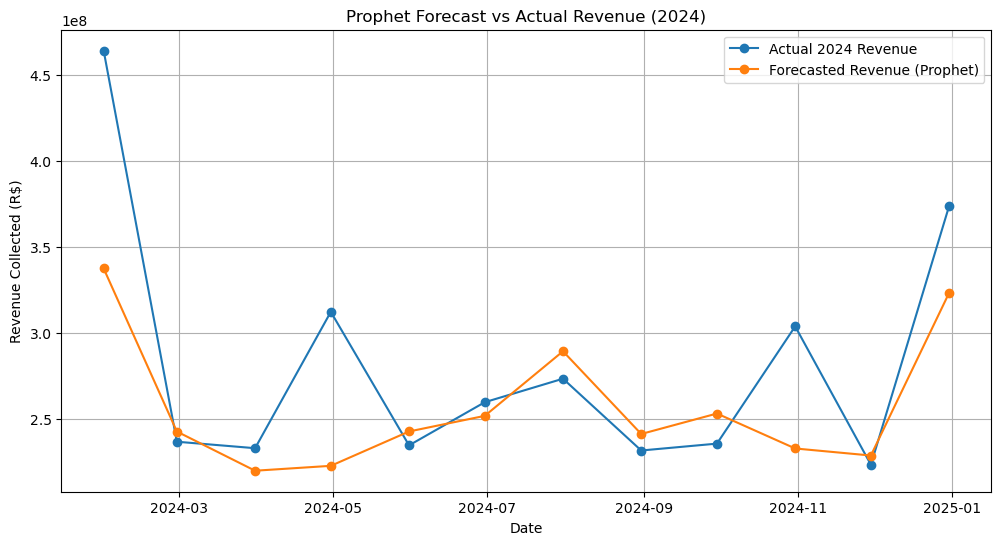

In [47]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))

plt.plot(compare_df['ds'], compare_df['actual'], label='Actual 2024 Revenue', marker='o')
plt.plot(compare_df['ds'], compare_df['yhat'], label='Forecasted Revenue (Prophet)', marker='o')

plt.title('Prophet Forecast vs Actual Revenue (2024)')
plt.xlabel('Date')
plt.ylabel('Revenue Collected (R$)')
plt.legend()
plt.grid(True)
plt.show()


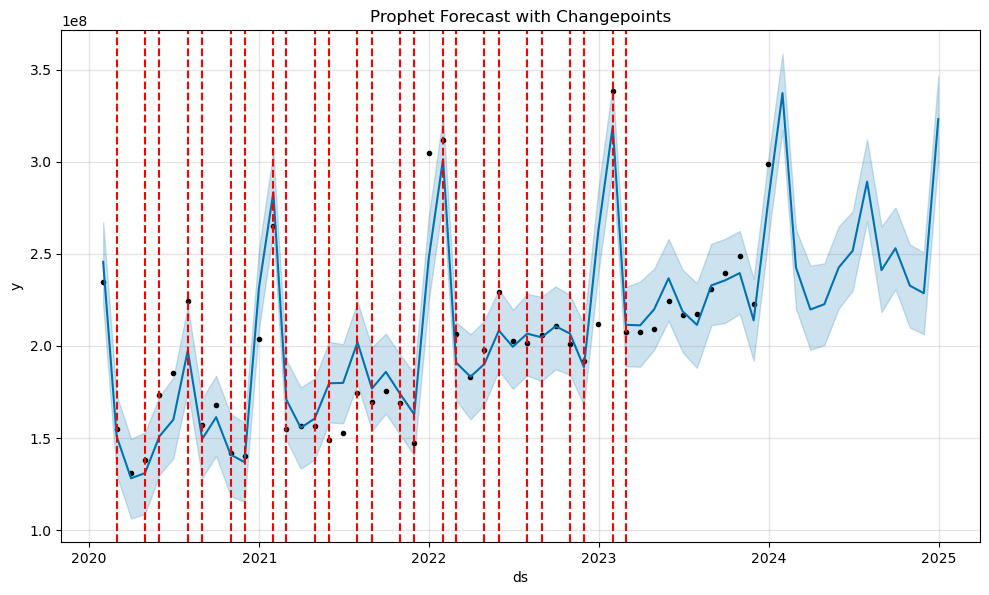

In [48]:
# Plot forecast
fig1 = model.plot(forecast)

# Add changepoint lines to the plot
for changepoint in model.changepoints:
    plt.axvline(changepoint, color='red', linestyle='--')

plt.title('Prophet Forecast with Changepoints')
plt.show()


In [57]:
# 2025 Revenue Forecasting

future = model.make_future_dataframe(periods=24, freq='ME')

# Predict into the future
forecast = model.predict(future)

# Filter for 2025 predictions only
forecast_2025 = forecast[
    (forecast['ds'] >= '2025-01-01') & (forecast['ds'] <= '2025-12-31')
]

# Show results
forecast_2025[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]


,ds,yhat,yhat_lower,yhat_upper
60,2025-01-31,"375,187,085.07","353,476,694.84","398,974,076.86"
61,2025-02-28,"262,490,538.63","240,939,686.66","285,112,657.06"
62,2025-03-31,"247,243,434.88","225,701,609.19","269,848,599.82"
63,2025-04-30,"252,265,120.65","229,225,840.97","272,813,125.00"
64,2025-05-31,"271,436,414.08","249,322,257.52","294,665,772.34"
65,2025-06-30,"271,618,327.67","249,736,825.02","294,568,356.79"
66,2025-07-31,"293,728,694.74","271,663,107.32","315,687,852.90"
67,2025-08-31,"268,560,733.02","245,548,315.09","292,002,526.47"
68,2025-09-30,"277,615,648.87","254,615,892.95","299,422,905.08"
69,2025-10-31,"265,541,727.79","243,330,950.89","288,618,636.88"


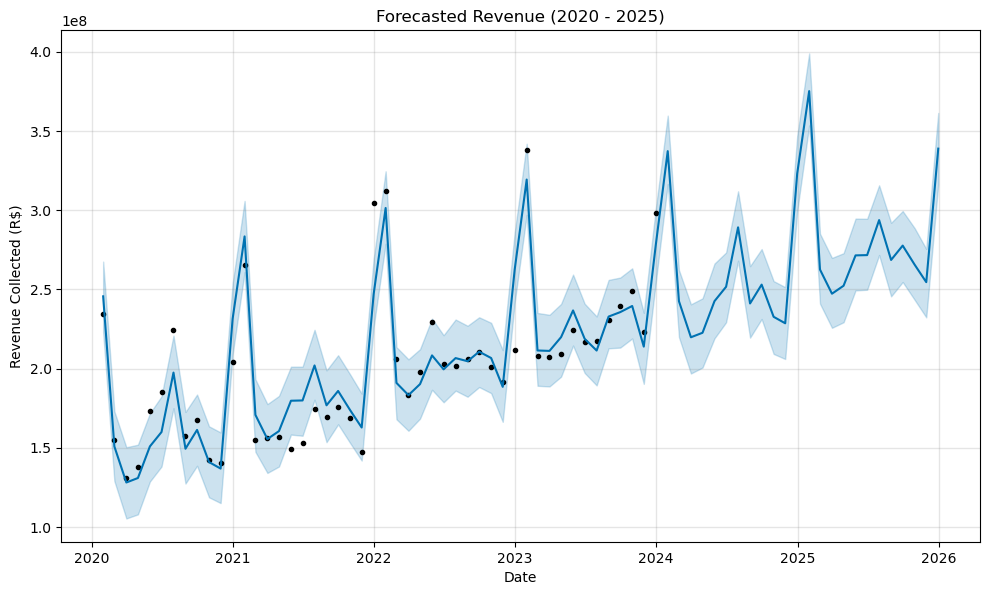

In [58]:
fig1 = model.plot(forecast)
plt.title("Forecasted Revenue (2020 - 2025)")
plt.xlabel("Date")
plt.ylabel("Revenue Collected (R$)")
plt.show()


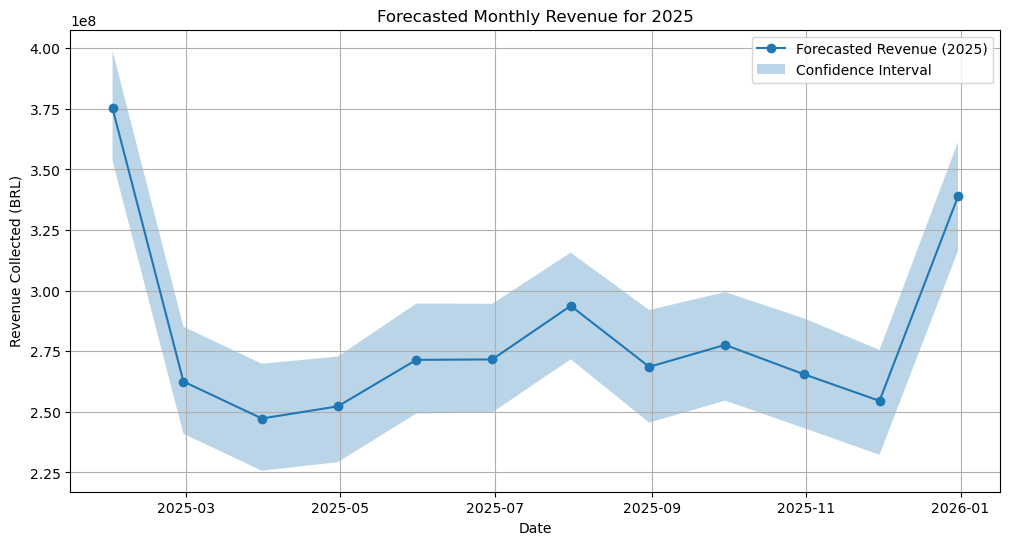

In [60]:
plt.figure(figsize=(12,6))
plt.plot(forecast_2025['ds'], forecast_2025['yhat'], marker='o', label='Forecasted Revenue (2025)')
plt.fill_between(forecast_2025['ds'], forecast_2025['yhat_lower'], forecast_2025['yhat_upper'], alpha=0.3, label='Confidence Interval')
plt.title('Forecasted Monthly Revenue for 2025')
plt.xlabel('Date')
plt.ylabel('Revenue Collected (BRL)')
plt.legend()
plt.grid(True)
plt.show()


In [61]:
forecast_2025[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].to_csv('forecasted_revenue_2025.csv', index=False)
print("✅ Forecast exported as 'forecasted_revenue_2025.csv'")


✅ Forecast exported as 'forecasted_revenue_2025.csv'


In [63]:
# Forecast by Origin

# Filter to only include collected revenue (Arrecadação de receita)
collected_revenue_df = df_collected[df_collected['movement_type'] == 'Arrecadação de receita']

# Group by date (month) and origin, summing the revenue values
monthly_origin_revenue = collected_revenue_df.groupby([
    pd.Grouper(key='movement_date', freq='ME'),
    'origin'
])['movement_value'].sum().reset_index()

# Preview the grouped data
print(monthly_origin_revenue.head())


  movement_date                                       origin  movement_value
0    2020-01-31                                Contribuições    7,299,039.25
1    2020-01-31  Impostos, Taxas e Contribuições de Melhoria  140,919,745.36
2    2020-01-31                    Outras Receitas Correntes    1,091,101.96
3    2020-01-31                         Receita Agropecuária           22.83
4    2020-01-31                          Receita Patrimonial    2,525,598.72


In [64]:
# Get all unique origins in the dataset
unique_origins = monthly_origin_revenue['origin'].unique()

# Create dictionaries to store models and forecasts
prophet_models_by_origin = {}
forecasts_by_origin = {}

# Loop through each origin and create a separate Prophet model and forecast
for origin_name in unique_origins:
    print(f"🔮 Forecasting revenue for Origin: {origin_name}")
    
    # Filter data for the current origin
    origin_data = monthly_origin_revenue[monthly_origin_revenue['origin'] == origin_name]
    
    # Rename columns to match Prophet's expected format
    prophet_df = origin_data.rename(columns={
        'movement_date': 'ds',
        'movement_value': 'y'
    })
    
    # Create and configure Prophet model
    prophet_model = Prophet(
        changepoint_prior_scale=0.3,           # Flexibility in trend changes
        seasonality_mode='multiplicative'      # Revenue grows with variance
    )
    
    # Add custom monthly seasonality to capture monthly fluctuations
    prophet_model.add_seasonality(
        name='monthly',
        period=30.5,
        fourier_order=5
    )
    
    # Fit the model on the data for this origin
    prophet_model.fit(prophet_df)
    
    # Create a future dataframe to predict 24 months ahead (2024 + 2025)
    future_dates = prophet_model.make_future_dataframe(periods=24, freq='M')
    
    # Generate the forecast
    forecast_df = prophet_model.predict(future_dates)
    
    # Store the model and forecast for this origin
    prophet_models_by_origin[origin_name] = prophet_model
    forecasts_by_origin[origin_name] = forecast_df
    
    print(f"✅ Completed forecast for origin: {origin_name}")


15:08:40 - cmdstanpy - INFO - Chain [1] start processing


🔮 Forecasting revenue for Origin: Contribuições


15:08:41 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\jeffe\anaconda3\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
15:08:42 - cmdstanpy - INFO - Chain [1] start processing


✅ Completed forecast for origin: Contribuições
🔮 Forecasting revenue for Origin: Impostos, Taxas e Contribuições de Melhoria


15:08:43 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\jeffe\anaconda3\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
15:08:43 - cmdstanpy - INFO - Chain [1] start processing


✅ Completed forecast for origin: Impostos, Taxas e Contribuições de Melhoria
🔮 Forecasting revenue for Origin: Outras Receitas Correntes


15:08:44 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\jeffe\anaconda3\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
15:08:44 - cmdstanpy - INFO - Chain [1] start processing


✅ Completed forecast for origin: Outras Receitas Correntes
🔮 Forecasting revenue for Origin: Receita Agropecuária


15:08:44 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\jeffe\anaconda3\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
15:08:45 - cmdstanpy - INFO - Chain [1] start processing


✅ Completed forecast for origin: Receita Agropecuária
🔮 Forecasting revenue for Origin: Receita Patrimonial


15:08:46 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\jeffe\anaconda3\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
15:08:46 - cmdstanpy - INFO - Chain [1] start processing


✅ Completed forecast for origin: Receita Patrimonial
🔮 Forecasting revenue for Origin: Receita de Serviços


15:08:47 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\jeffe\anaconda3\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
15:08:47 - cmdstanpy - INFO - Chain [1] start processing


✅ Completed forecast for origin: Receita de Serviços
🔮 Forecasting revenue for Origin: Transferências Correntes


15:08:48 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\jeffe\anaconda3\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
15:08:48 - cmdstanpy - INFO - Chain [1] start processing


✅ Completed forecast for origin: Transferências Correntes
🔮 Forecasting revenue for Origin: Transferências de Capital


15:08:48 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\jeffe\anaconda3\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
15:08:49 - cmdstanpy - INFO - Chain [1] start processing


✅ Completed forecast for origin: Transferências de Capital
🔮 Forecasting revenue for Origin: Operações de Crédito


15:08:49 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\jeffe\anaconda3\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
15:08:49 - cmdstanpy - INFO - Chain [1] start processing


✅ Completed forecast for origin: Operações de Crédito
🔮 Forecasting revenue for Origin: Outras Receitas Correntes - Intraorçamentária


15:08:57 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\jeffe\anaconda3\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
15:08:57 - cmdstanpy - INFO - Chain [1] start processing


✅ Completed forecast for origin: Outras Receitas Correntes - Intraorçamentária
🔮 Forecasting revenue for Origin: Alienação de Bens


15:09:20 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\jeffe\anaconda3\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


✅ Completed forecast for origin: Alienação de Bens
🔮 Forecasting revenue for Origin: Outras Receitas de Capital


ValueError: Dataframe has less than 2 non-NaN rows.

In [65]:
# Example: Get forecast for a specific origin
selected_origin = 'Impostos, Taxas e Contribuições de Melhoria'  # Example name

forecast_for_origin = forecasts_by_origin[selected_origin]

# Filter for 2025 forecasts only
forecast_for_origin_2025 = forecast_for_origin[
    (forecast_for_origin['ds'] >= '2025-01-01') & (forecast_for_origin['ds'] <= '2025-12-31')
]

# Display the forecast results
forecast_for_origin_2025[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]


,ds,yhat,yhat_lower,yhat_upper
60,2025-01-31,"254,999,105.17","247,912,243.69","262,438,898.41"
61,2025-02-28,"59,983,151.46","53,374,394.51","66,830,601.57"
62,2025-03-31,"63,085,063.66","54,011,028.84","73,505,652.59"
63,2025-04-30,"49,146,186.81","38,473,125.46","59,689,095.52"
64,2025-05-31,"68,151,725.82","48,290,545.76","88,086,153.45"
65,2025-06-30,"51,281,062.59","31,733,956.57","71,440,538.81"
66,2025-07-31,"70,987,750.26","36,712,941.95","105,709,750.38"
67,2025-08-31,"80,601,512.13","34,861,169.57","129,464,309.63"
68,2025-09-30,"70,286,688.60","23,387,166.08","119,153,066.00"
69,2025-10-31,"83,959,309.13","20,350,578.74","151,496,389.66"


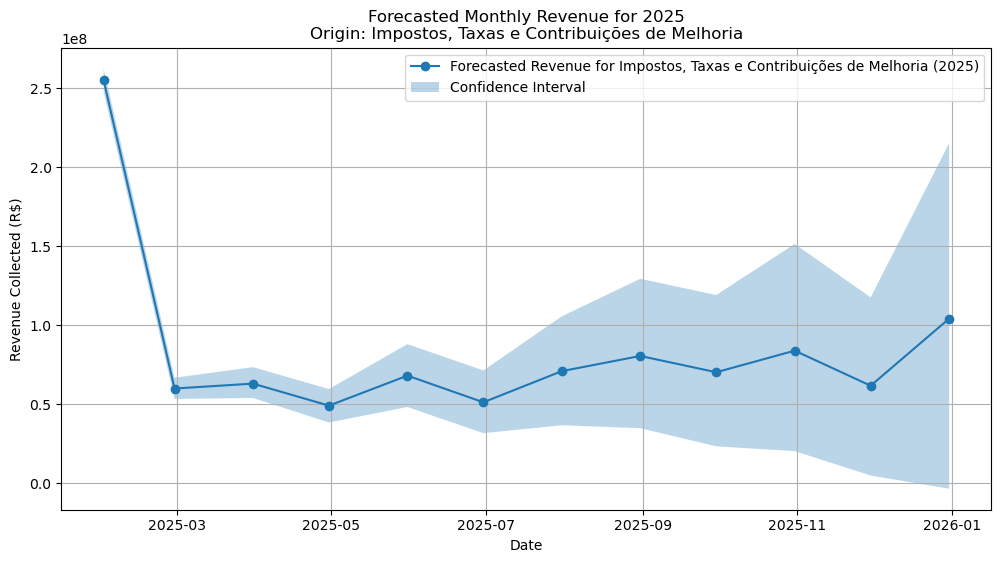

In [66]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.plot(
    forecast_for_origin_2025['ds'],
    forecast_for_origin_2025['yhat'],
    marker='o',
    label=f'Forecasted Revenue for {selected_origin} (2025)'
)

plt.fill_between(
    forecast_for_origin_2025['ds'],
    forecast_for_origin_2025['yhat_lower'],
    forecast_for_origin_2025['yhat_upper'],
    alpha=0.3,
    label='Confidence Interval'
)

plt.title(f'Forecasted Monthly Revenue for 2025\nOrigin: {selected_origin}')
plt.xlabel('Date')
plt.ylabel('Revenue Collected (R$)')
plt.legend()
plt.grid(True)
plt.show()


In [68]:
# Export forecasts for each origin for 2025 to separate CSV files

for origin_name in forecasts_by_origin.keys():
    forecast_df = forecasts_by_origin[origin_name]
    
    # Filter forecast for 2025 only
    forecast_2025_df = forecast_df[
        (forecast_df['ds'] >= '2025-01-01') & (forecast_df['ds'] <= '2025-12-31')
    ]
    
    # Clean origin name for filenames
    cleaned_origin_name = origin_name.replace(" ", "_").replace(",", "").replace("/", "-")
    
    # Export forecast to CSV
    file_name = f'forecasted_revenue_2025_{cleaned_origin_name}.csv'
    forecast_2025_df[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].to_csv(file_name, index=False)
    
    print(f"✅ Exported forecast for {origin_name} to {file_name}")



✅ Exported forecast for Contribuições to forecasted_revenue_2025_Contribuições.csv
✅ Exported forecast for Impostos, Taxas e Contribuições de Melhoria to forecasted_revenue_2025_Impostos_Taxas_e_Contribuições_de_Melhoria.csv
✅ Exported forecast for Outras Receitas Correntes to forecasted_revenue_2025_Outras_Receitas_Correntes.csv
✅ Exported forecast for Receita Agropecuária to forecasted_revenue_2025_Receita_Agropecuária.csv
✅ Exported forecast for Receita Patrimonial to forecasted_revenue_2025_Receita_Patrimonial.csv
✅ Exported forecast for Receita de Serviços to forecasted_revenue_2025_Receita_de_Serviços.csv
✅ Exported forecast for Transferências Correntes to forecasted_revenue_2025_Transferências_Correntes.csv
✅ Exported forecast for Transferências de Capital to forecasted_revenue_2025_Transferências_de_Capital.csv
✅ Exported forecast for Operações de Crédito to forecasted_revenue_2025_Operações_de_Crédito.csv
✅ Exported forecast for Outras Receitas Correntes - Intraorçamentária to